In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from torchmetrics.classification import BinaryAccuracy
import seaborn as sns
import joblib
import os
os.makedirs("4_Top_results", exist_ok=True)


In [15]:

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = '/home/sandeep/Desktop/Windows files/project rootfiles/13TeV_signal_5k.root'
# background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
background_file = '/home/sandeep/Desktop/Windows files/project rootfiles/13TeV_BKG_5k.root'

tree_name = 'Delphes'
batch_size = 64
delta_r_threshold = 1.0


In [17]:

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data


In [18]:

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list


In [ ]:
# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="hypergraph")


In [20]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="hyper-best",
    monitor="val_roc_auc",
    mode="max",
    save_top_k=1,
    save_last=True
)


In [21]:

# Define LightningModule
class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.5
        self.y_true, self.y_score = [], []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
    #     x_event_pred = torch.zeros_like(batch.x_t.float())
    #     for i in range(len(batch.x_t)):
    #         x_event_pred[i] = x_hat[batch_hyper == i].mean()

    #     pred_probs = x_event_pred.detach().cpu().numpy()
    #     true_labels = batch.x_t.detach().cpu().numpy()
    #     self.y_score.extend(pred_probs)
    #     self.y_true.extend(true_labels)

    #     pred_class = (x_event_pred > 0.5).float()
    #     acc = (pred_class == batch.x_t.float()).float().mean()
    #     self.log('val_acc_hyper', acc, prog_bar=True)
    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)

        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        self.y_score.append(x_event_pred.detach().cpu())
        self.y_true.append(batch.x_t.detach().cpu())

        pred_class = (x_event_pred > 0.5).float()
        acc = (pred_class == batch.x_t.float()).float().mean()

        self.log('val_acc_hyper', acc, prog_bar=True, on_step=False, on_epoch=True)


    def on_validation_epoch_end(self):
        # y_true = np.array(self.y_true)
        # y_pred = np.array(self.y_score)
        # y_pred_class = (y_pred > 0.5).astype(int)

        # acc = accuracy_score(y_true, y_pred_class)
        # prec = precision_score(y_true, y_pred_class)
        # rec = recall_score(y_true, y_pred_class)
        # f1 = f1_score(y_true, y_pred_class)
        # roc = roc_auc_score(y_true, y_pred)

        # self.log('val_roc_auc', roc, prog_bar=True, on_epoch=True)
        # self.log('val_f1', f1, prog_bar=False, on_epoch=True)
        # self.log('val_precision', prec, prog_bar=False, on_epoch=True)
        # self.log('val_recall', rec, prog_bar=False, on_epoch=True)
        y_true = torch.cat(self.y_true).numpy()
        y_pred = torch.cat(self.y_score).numpy()
        y_pred_class = (y_pred > 0.5).astype(int)

        roc = roc_auc_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred_class)
        prec = precision_score(y_true, y_pred_class)
        rec  = recall_score(y_true, y_pred_class)

        self.log('val_roc_auc', roc, prog_bar=True)
        self.log('val_f1', f1)
        self.log('val_precision', prec)
        self.log('val_recall', rec)

        print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")
# Accuracy: {acc:.4f}, 
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid()
        plt.show()

        cm = confusion_matrix(y_true, y_pred_class)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # row-wise normalization

        sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

        plt.hist(y_pred[y_true == 1], bins=20, alpha=0.7, label='Signal', color='blue', density=True)
        plt.hist(y_pred[y_true == 0], bins=20, alpha=0.7, label='Background', color='red', density=True)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Signal vs Background Probabilities')
        plt.legend()
        plt.grid()
        plt.show()

        joblib.dump((y_true, y_pred), 'results/hyper_model_output.pkl')
        torch.save(self.state_dict(), 'results/hyper_model.pt')

        self.y_true.clear()
        self.y_score.clear()
        # self.y_true.clear()
        # self.y_score.clear()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.8,
    patience=10
)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc_hyper",
                "interval": "epoch",
                "strict": True,
            },
        }


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/sandeep/Desktop/Windows files/HyPER-main/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model           │ MPNNs          │ 14.0 K │ train │     0 │
│ 1 │ hyper           │ HyperedgeModel │  8.4 K │ train │     0 │
│ 2 │ criterion_edge  │ BCELoss        │      0 │ train │     0 │
│ 3 │ criterion_hyper │ BCELoss        │      0 │ train │     0 │
└───┴─────────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 22.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 58                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value 
of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: 
UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use 
`zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])

Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.1858

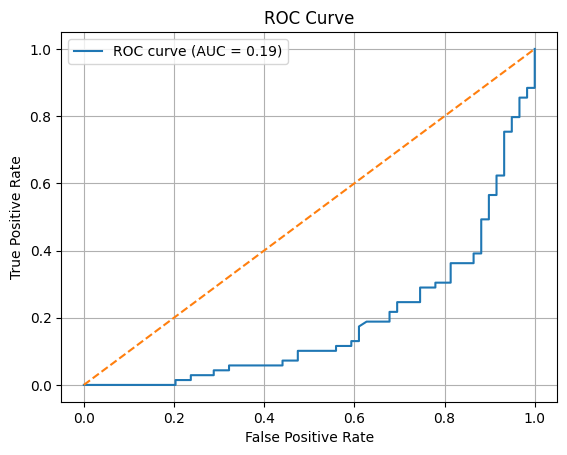

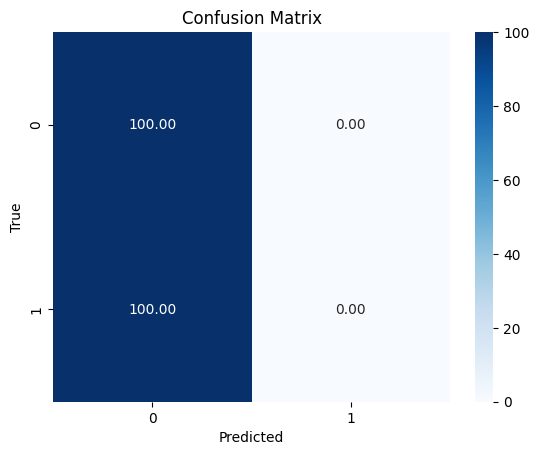

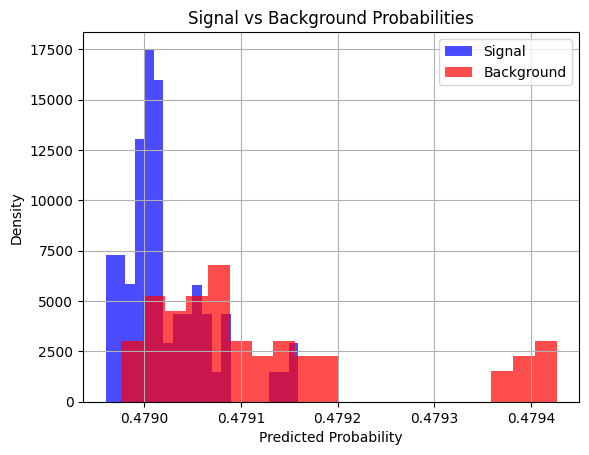

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Precision: 0.7702, Recall: 0.6774, F1: 0.7208, ROC AUC: 0.8161

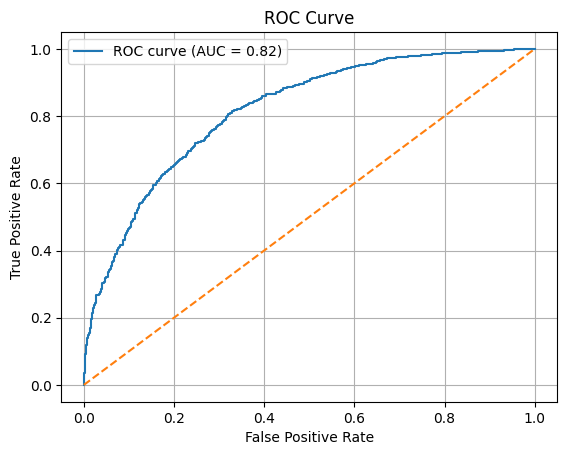

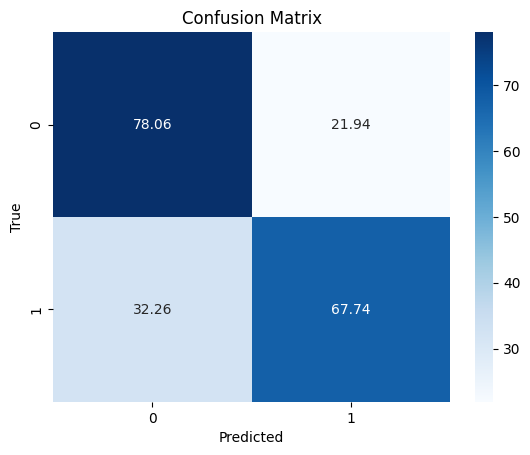

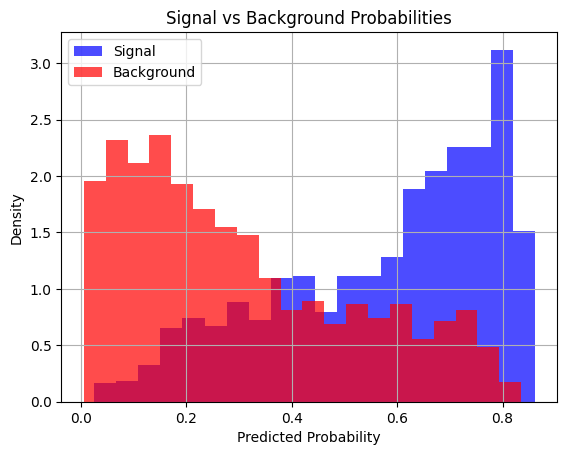

Precision: 0.7679, Recall: 0.8426, F1: 0.8035, ROC AUC: 0.8687

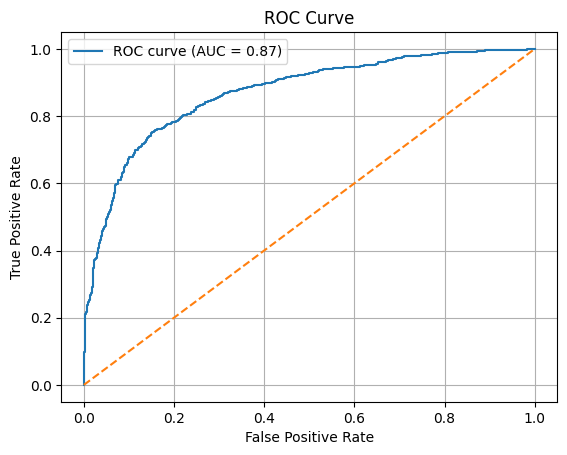

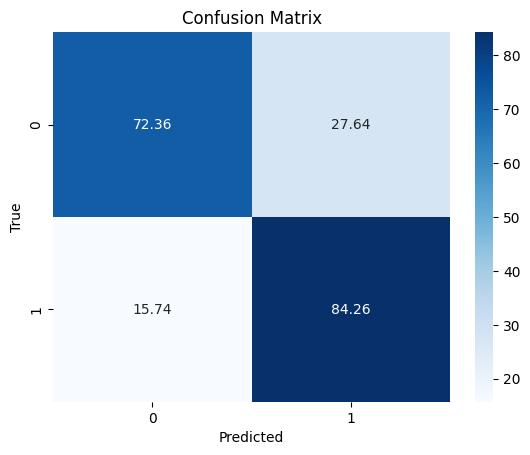

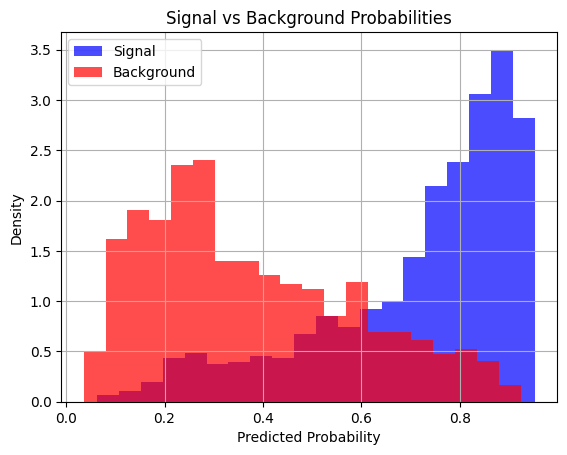

Precision: 0.8603, Recall: 0.7240, F1: 0.7863, ROC AUC: 0.8737

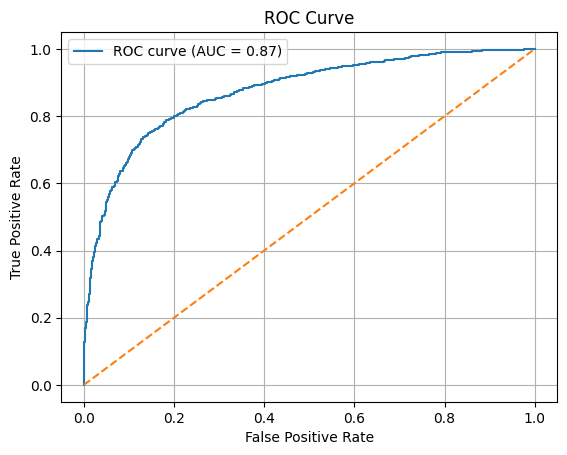

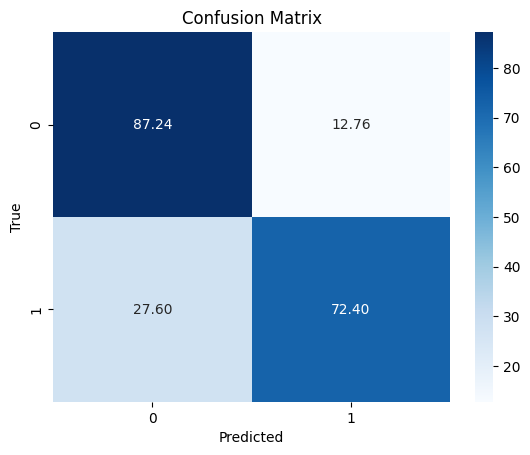

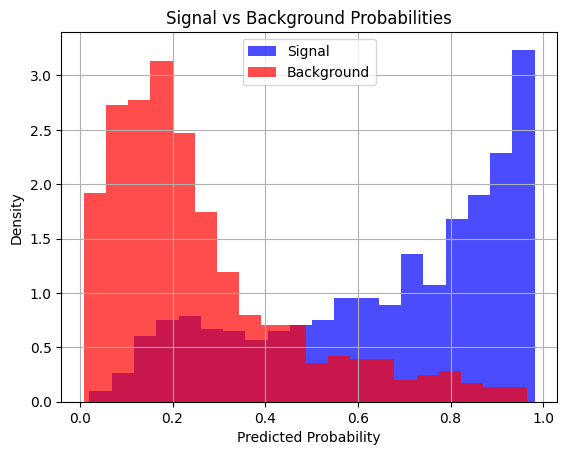

Precision: 0.9144, Recall: 0.6433, F1: 0.7553, ROC AUC: 0.8783

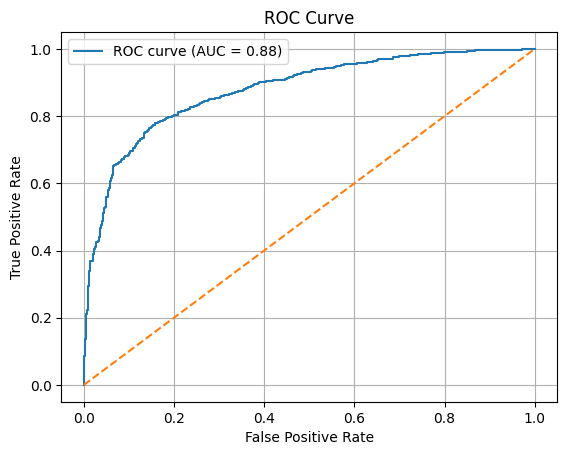

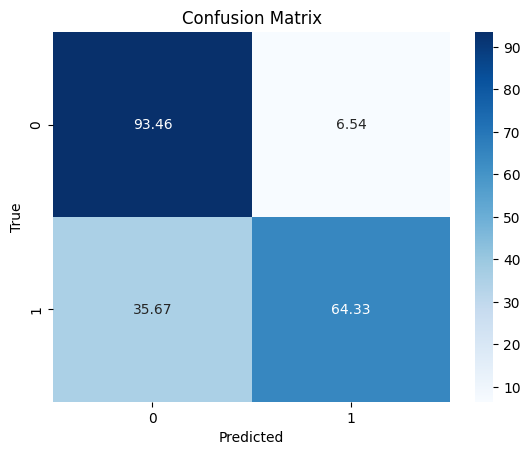

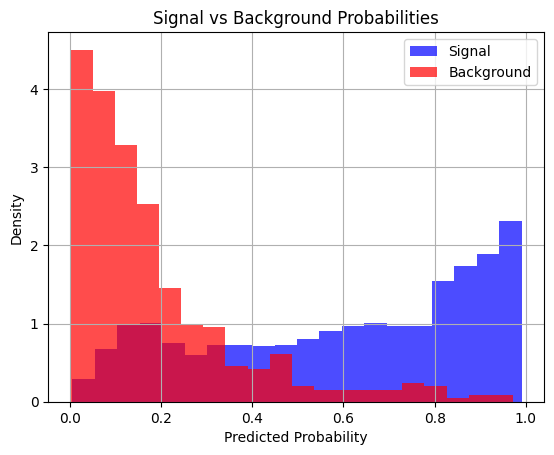

Precision: 0.8141, Recall: 0.8173, F1: 0.8157, ROC AUC: 0.8813

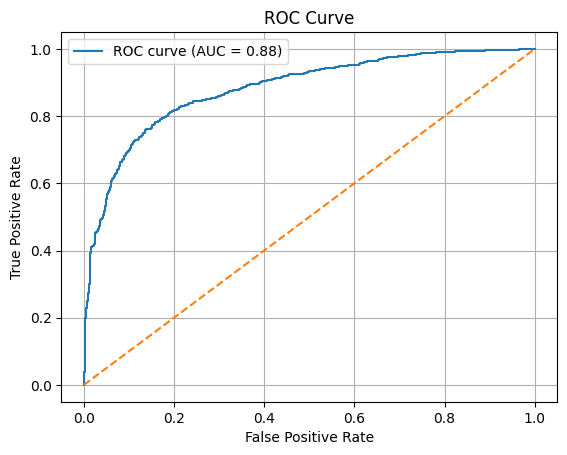

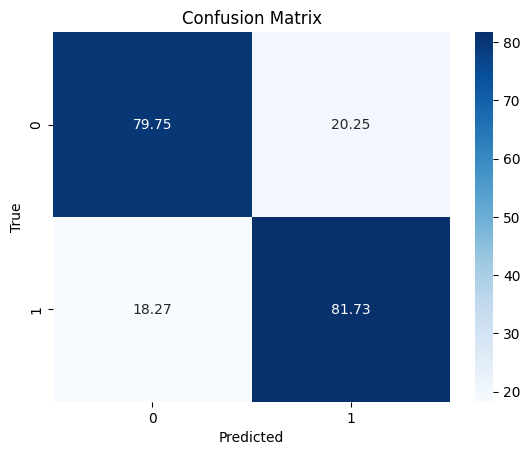

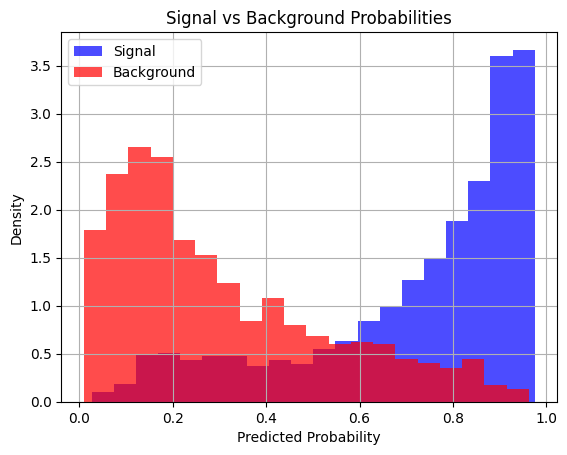

Precision: 0.8568, Recall: 0.7677, F1: 0.8098, ROC AUC: 0.8866

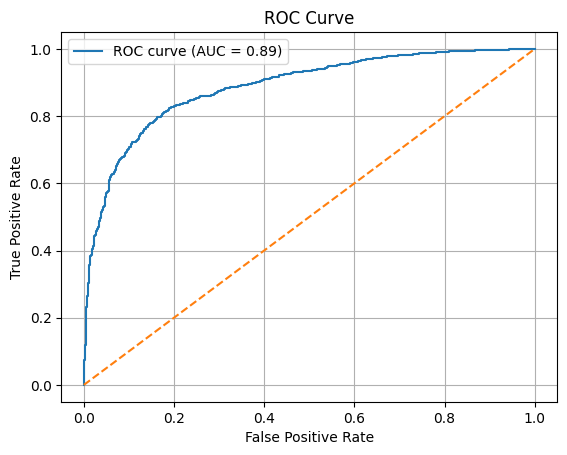

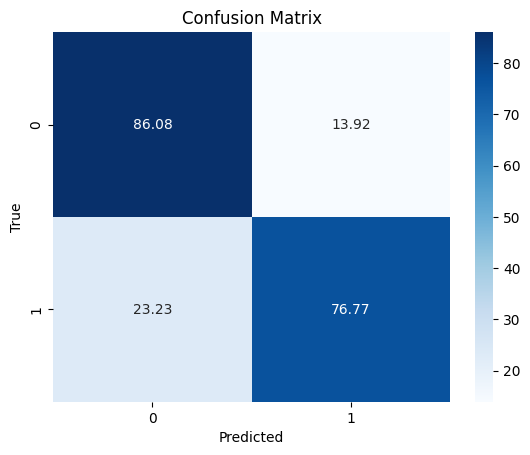

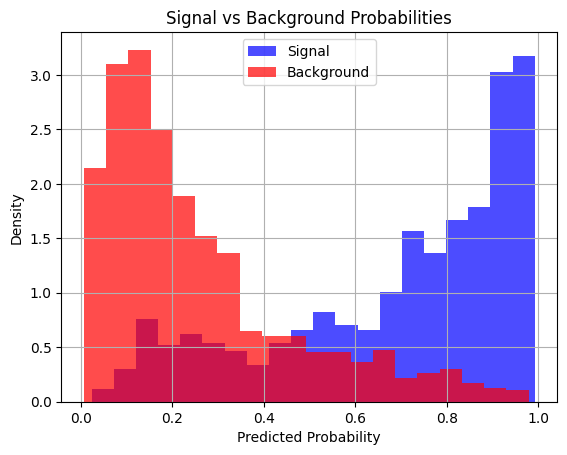

Precision: 0.8788, Recall: 0.7259, F1: 0.7951, ROC AUC: 0.8901

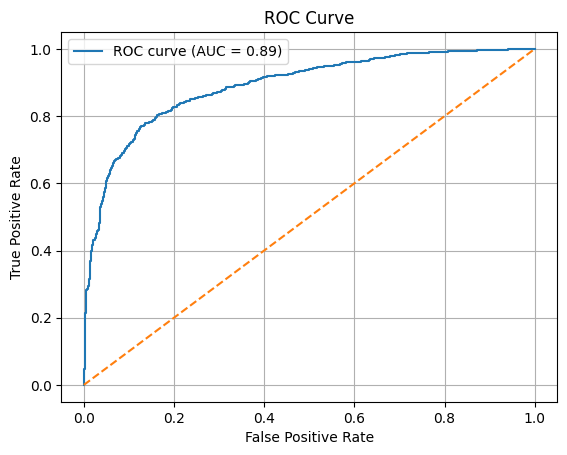

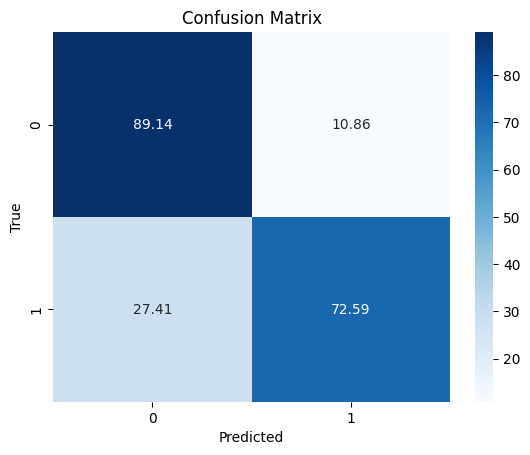

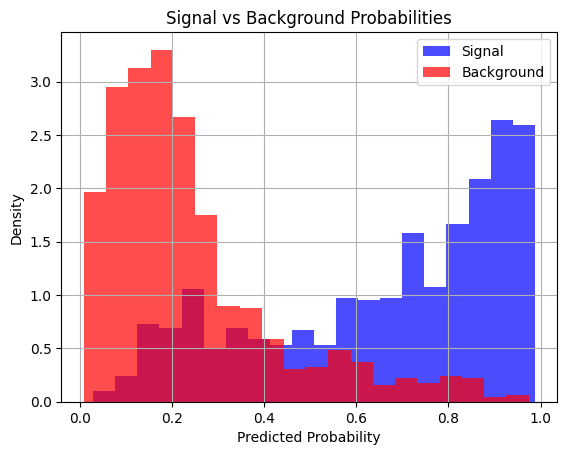

Precision: 0.8660, Recall: 0.7911, F1: 0.8268, ROC AUC: 0.8943

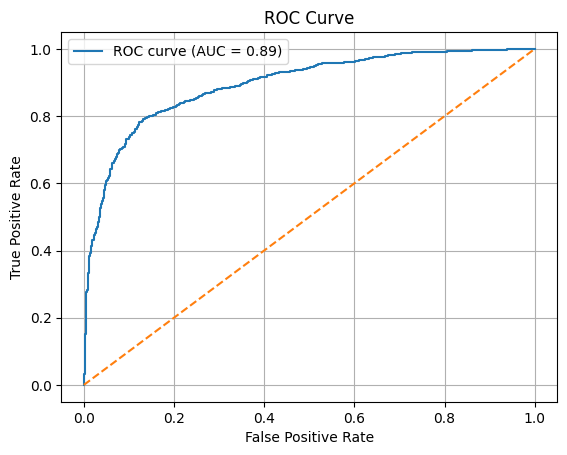

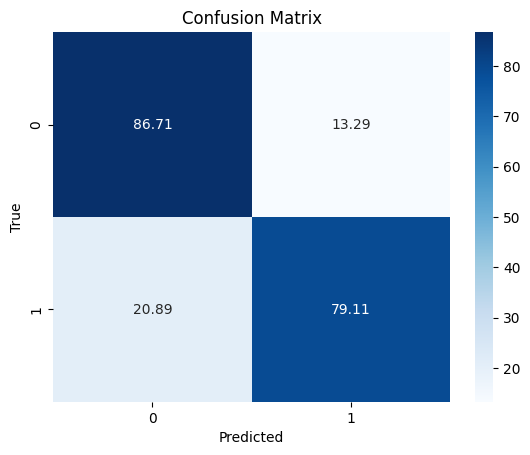

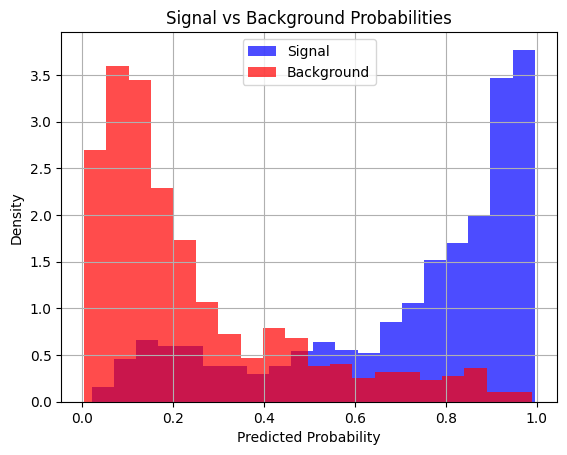

Precision: 0.8710, Recall: 0.7872, F1: 0.8270, ROC AUC: 0.9008

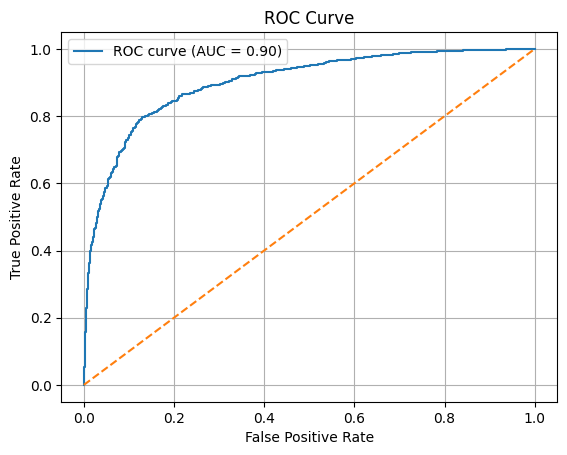

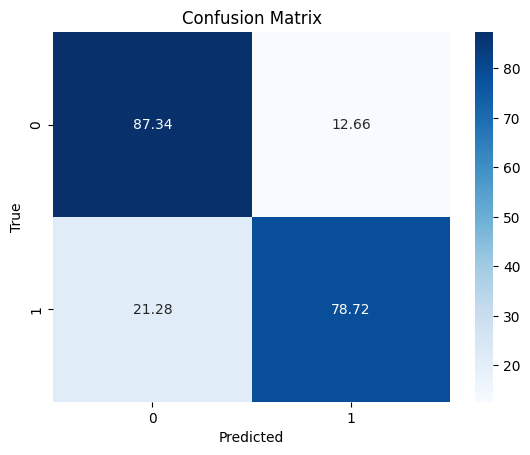

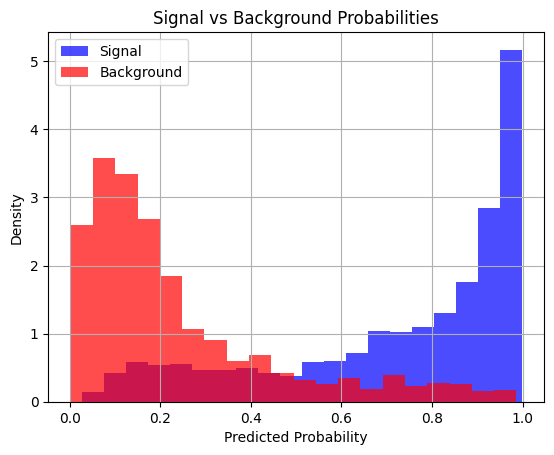

Precision: 0.8447, Recall: 0.8406, F1: 0.8427, ROC AUC: 0.9059

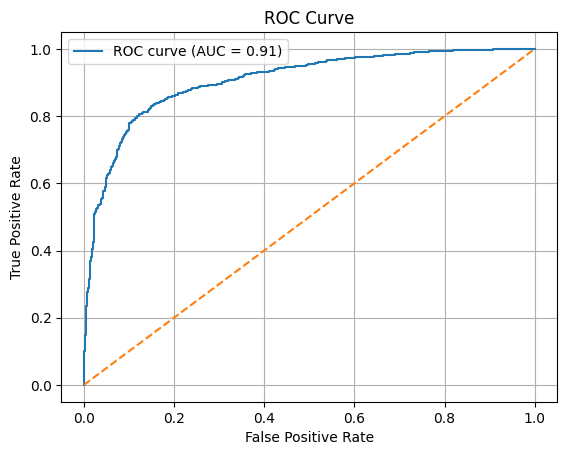

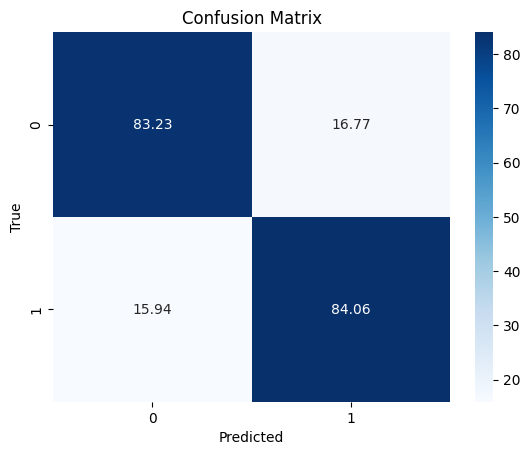

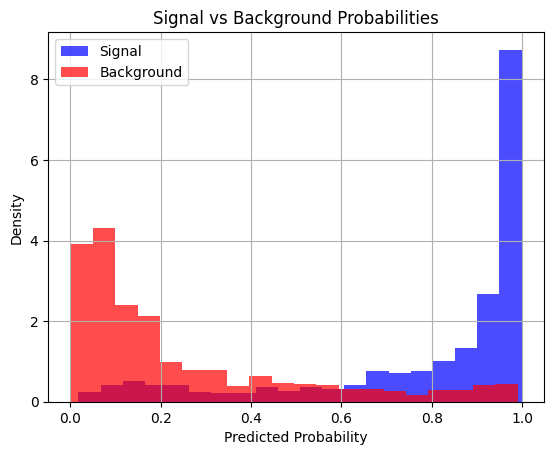

Precision: 0.8384, Recall: 0.8620, F1: 0.8500, ROC AUC: 0.9100

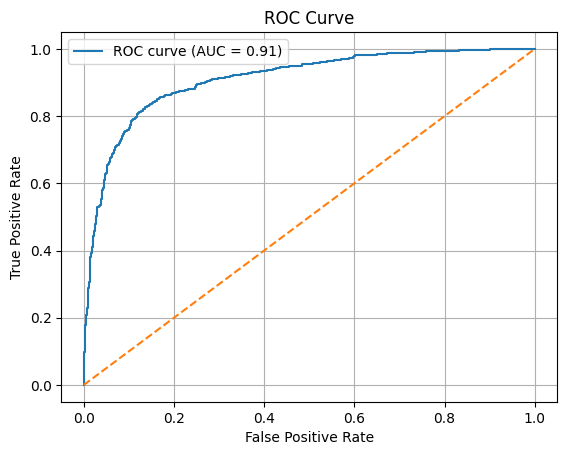

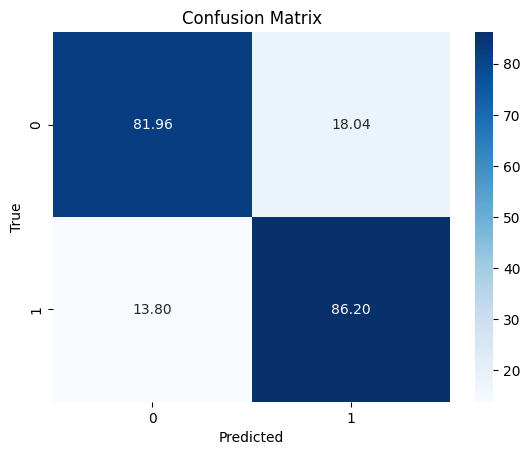

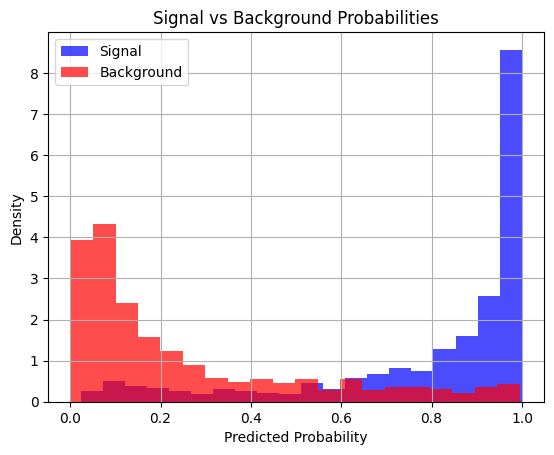

Precision: 0.8966, Recall: 0.7580, F1: 0.8215, ROC AUC: 0.9071

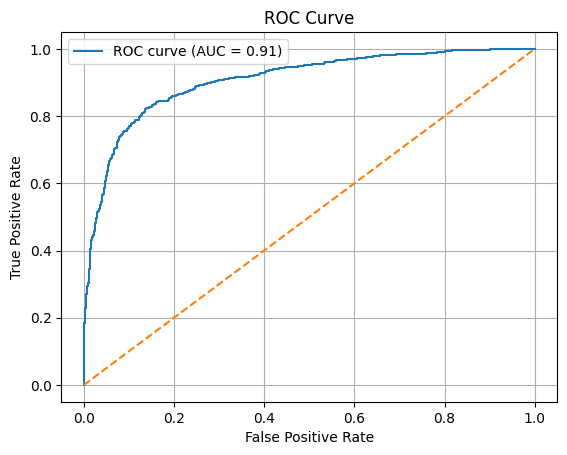

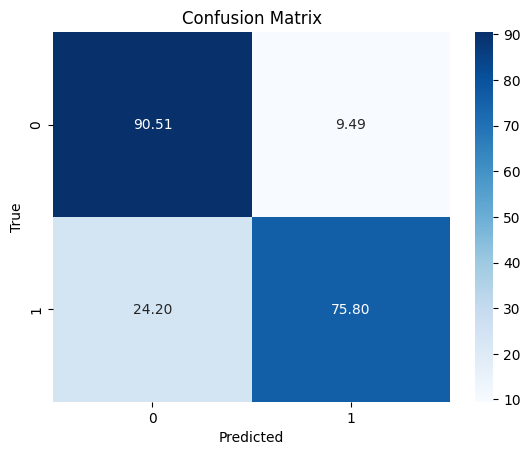

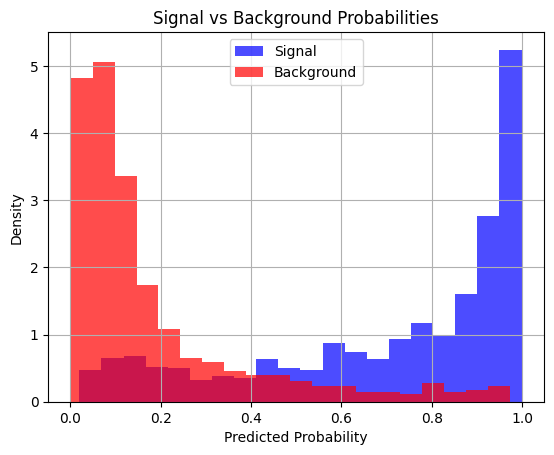

Precision: 0.9123, Recall: 0.7279, F1: 0.8097, ROC AUC: 0.9132

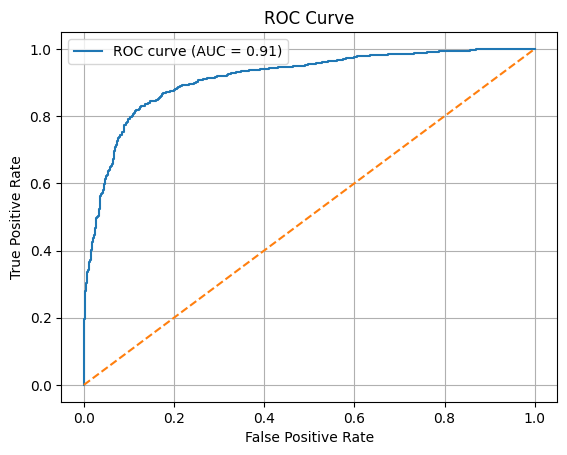

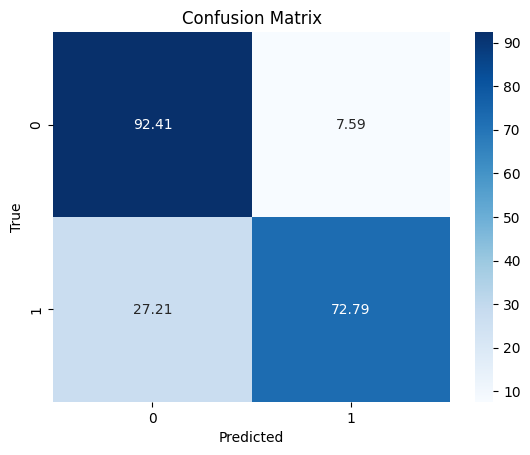

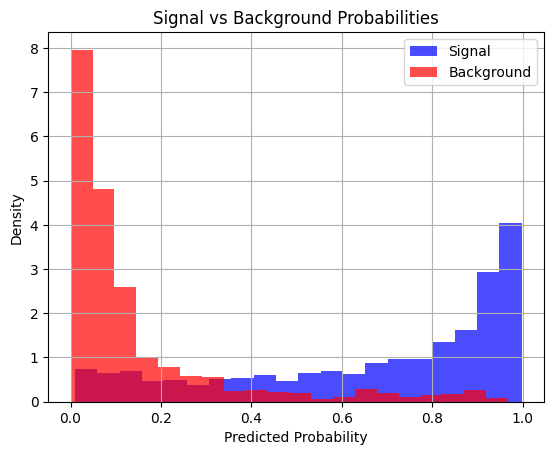

Precision: 0.8895, Recall: 0.7901, F1: 0.8369, ROC AUC: 0.9137

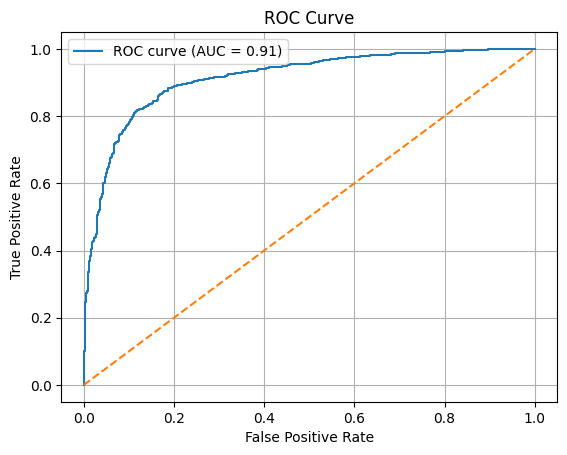

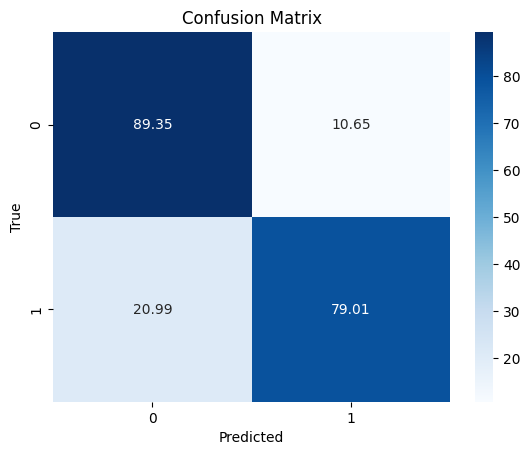

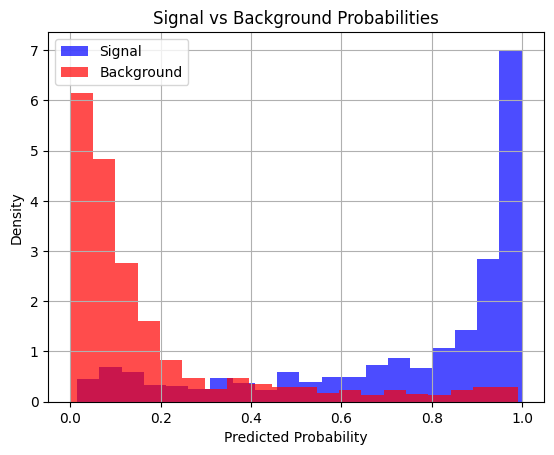

Precision: 0.8508, Recall: 0.8533, F1: 0.8520, ROC AUC: 0.9130

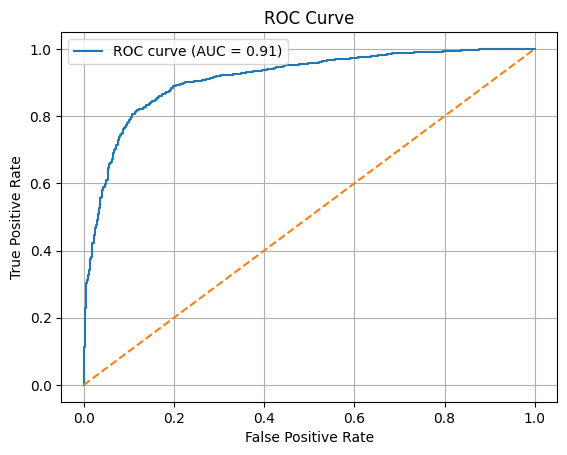

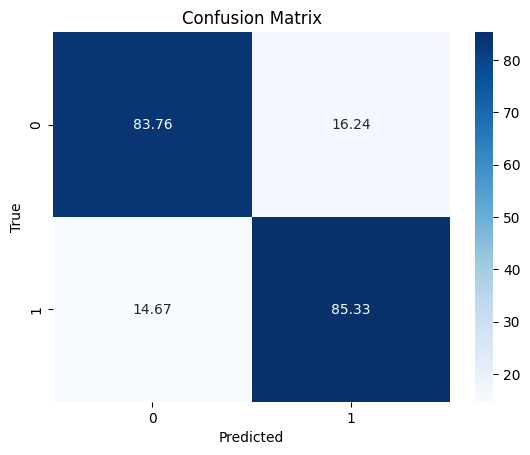

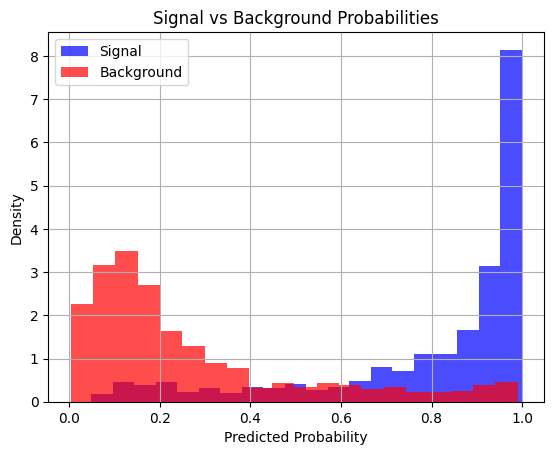

Precision: 0.8306, Recall: 0.8717, F1: 0.8506, ROC AUC: 0.9124

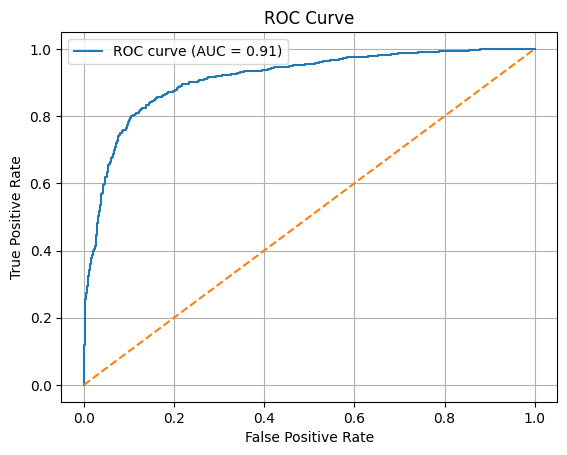

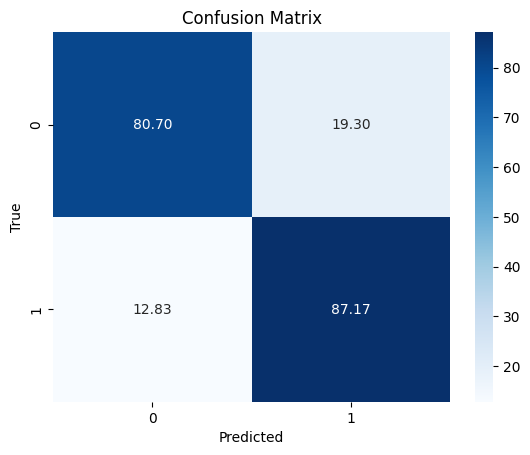

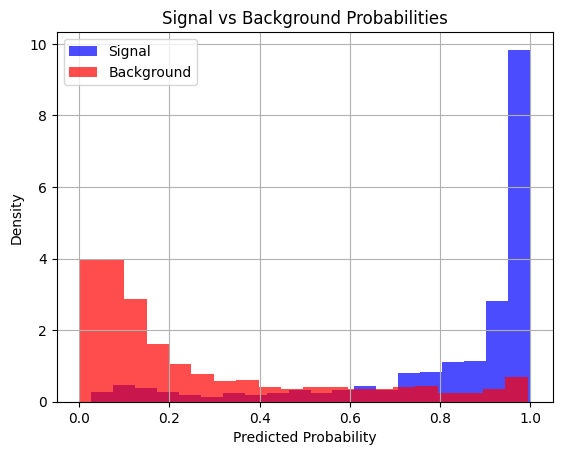

Precision: 0.8300, Recall: 0.8542, F1: 0.8420, ROC AUC: 0.9107

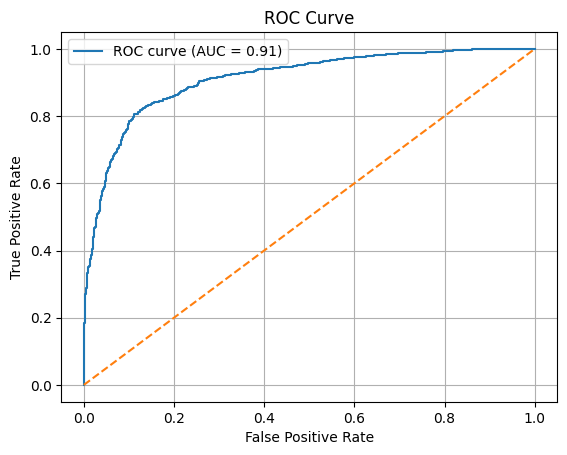

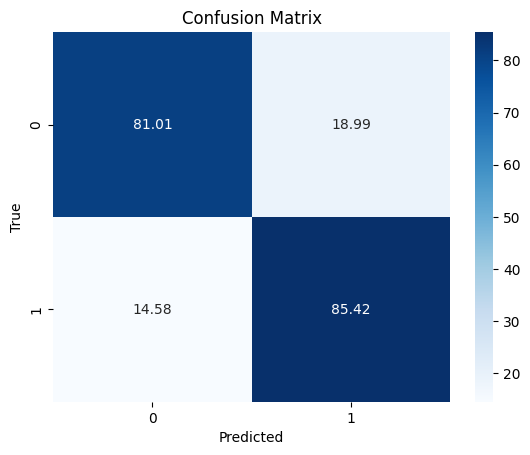

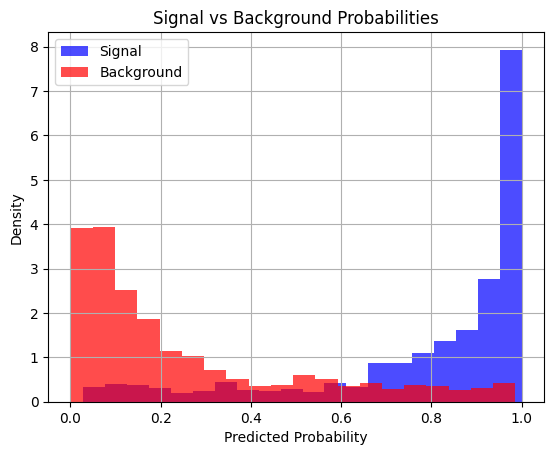

Precision: 0.9125, Recall: 0.6890, F1: 0.7852, ROC AUC: 0.9107

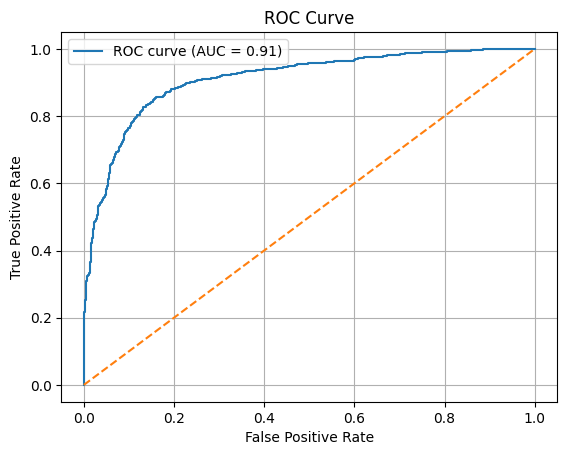

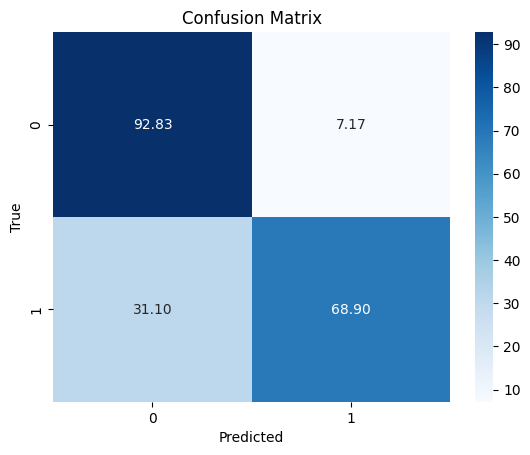

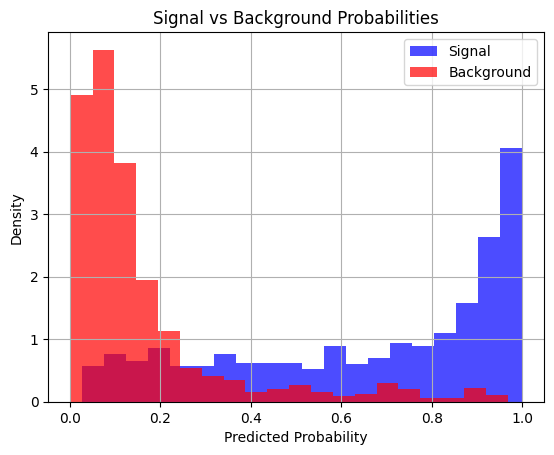

Precision: 0.9149, Recall: 0.7415, F1: 0.8191, ROC AUC: 0.9122

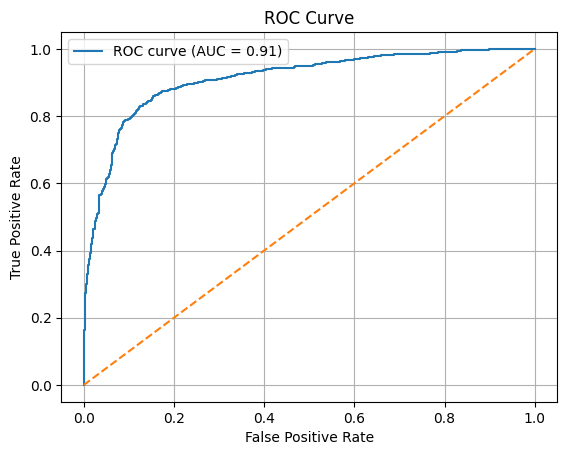

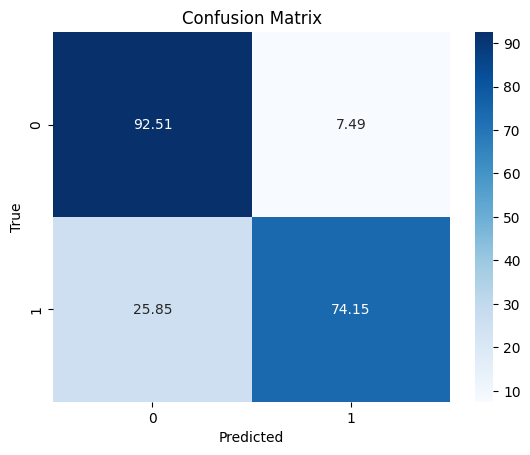

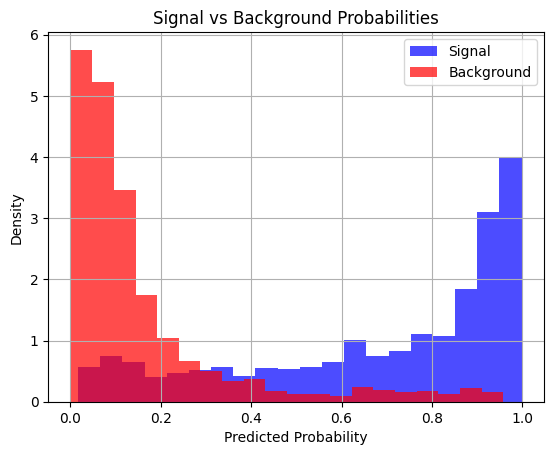

Precision: 0.8428, Recall: 0.8649, F1: 0.8537, ROC AUC: 0.9153

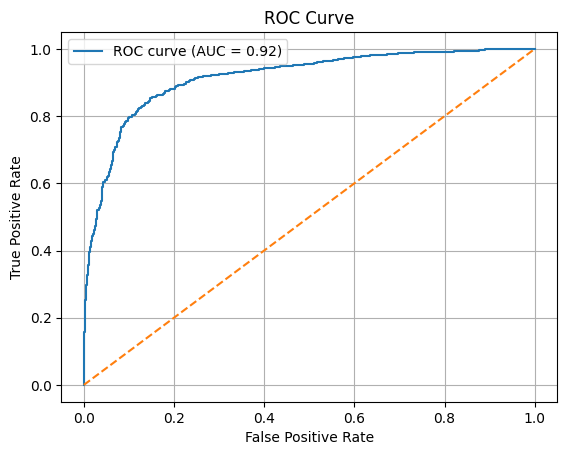

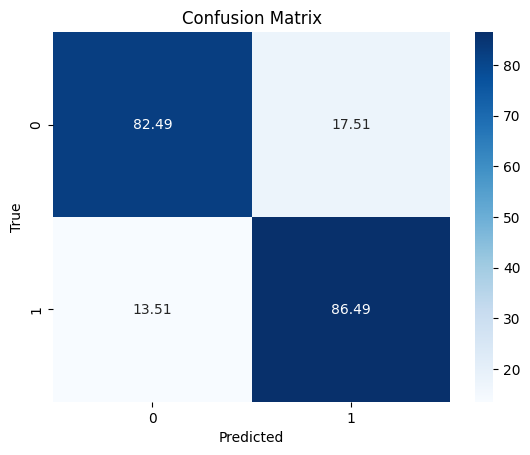

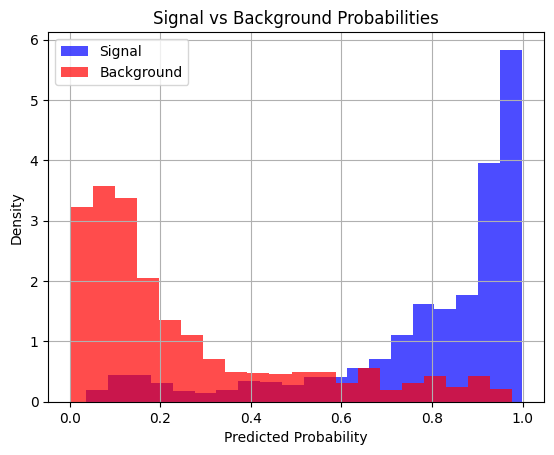

Precision: 0.8476, Recall: 0.8484, F1: 0.8480, ROC AUC: 0.9125

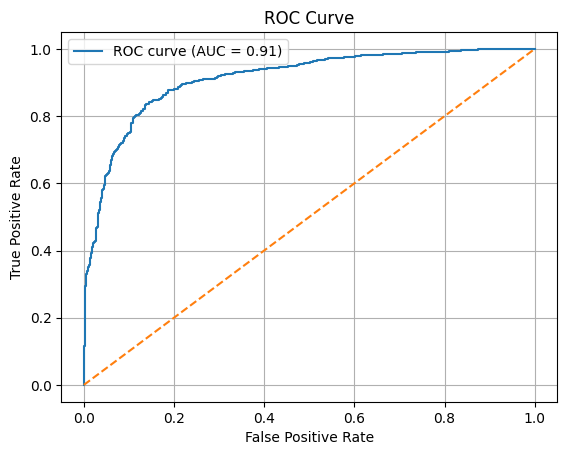

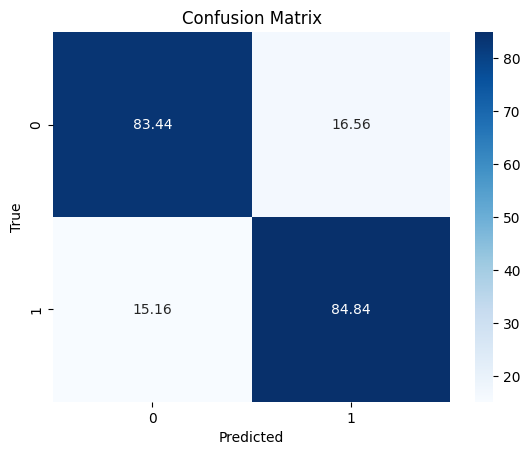

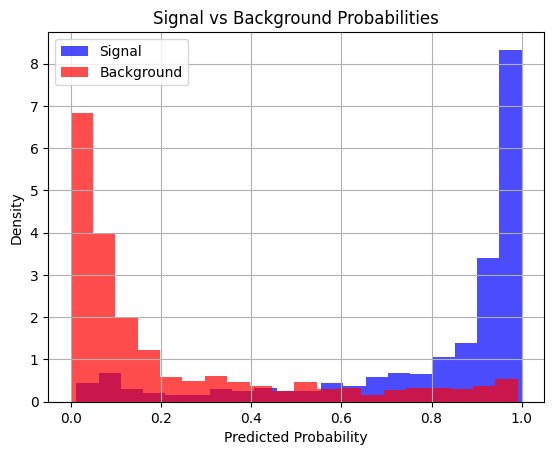

Precision: 0.8338, Recall: 0.8678, F1: 0.8505, ROC AUC: 0.9133

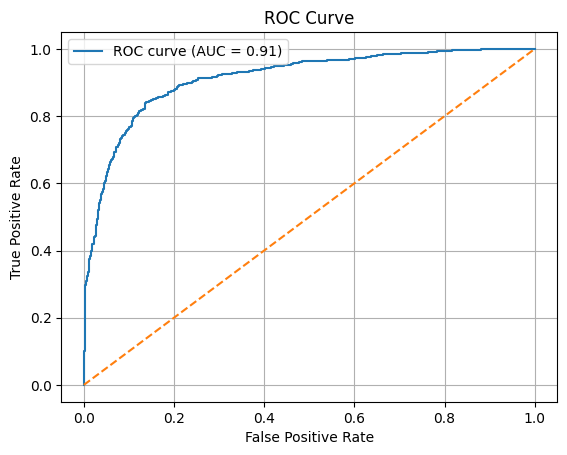

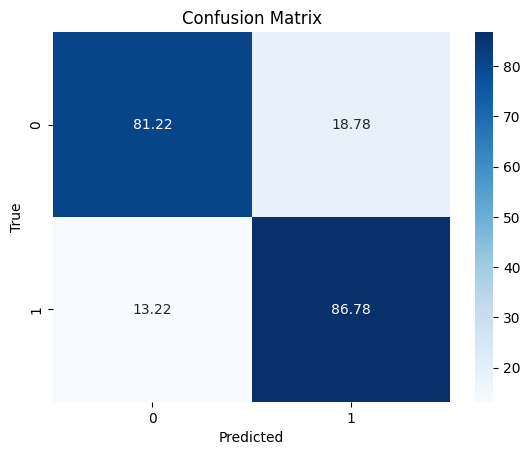

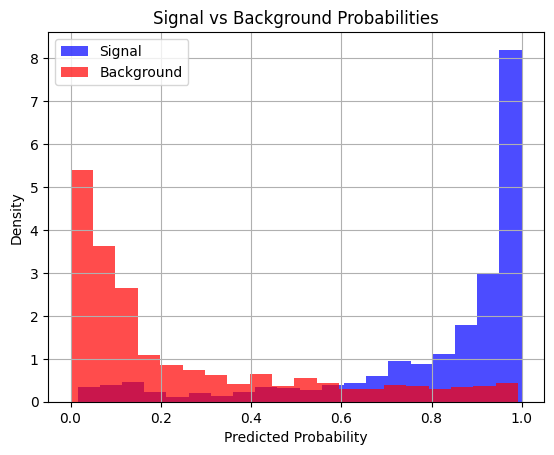

Precision: 0.8124, Recall: 0.8882, F1: 0.8487, ROC AUC: 0.9106

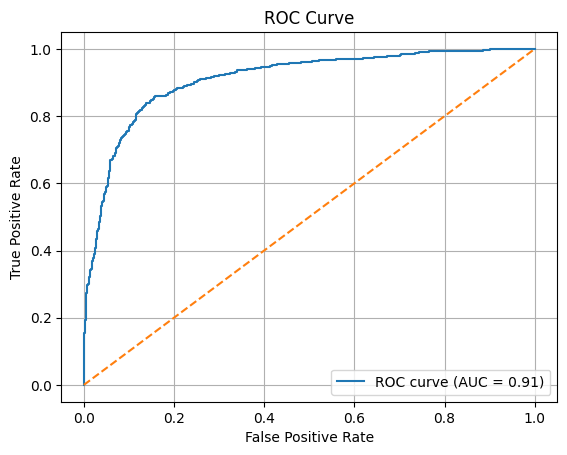

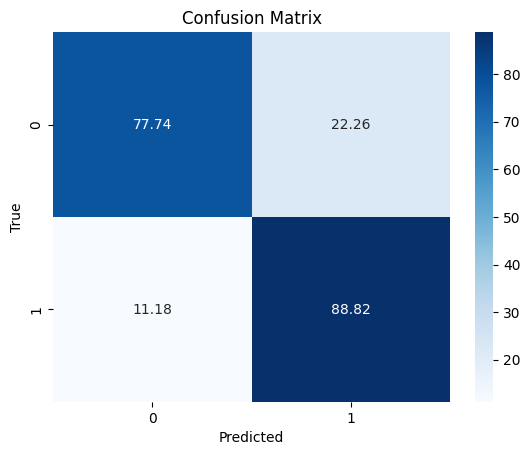

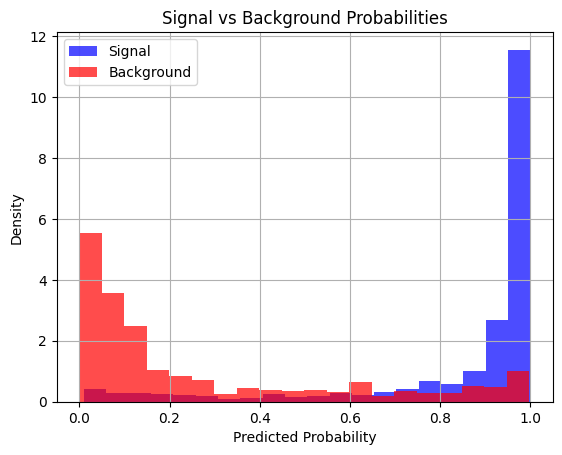

Precision: 0.8608, Recall: 0.8533, F1: 0.8570, ROC AUC: 0.9144

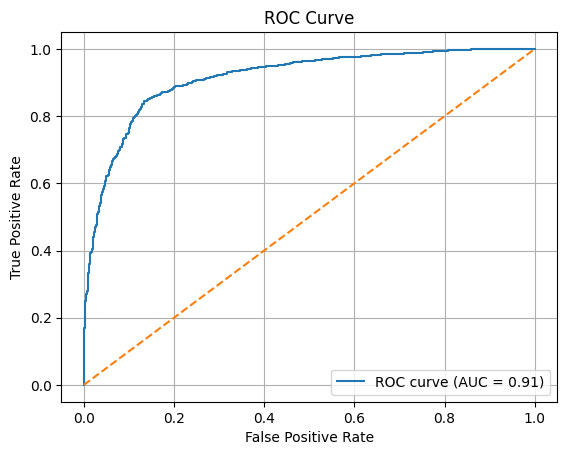

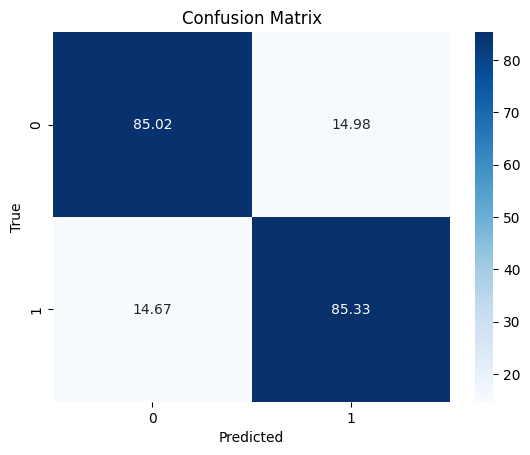

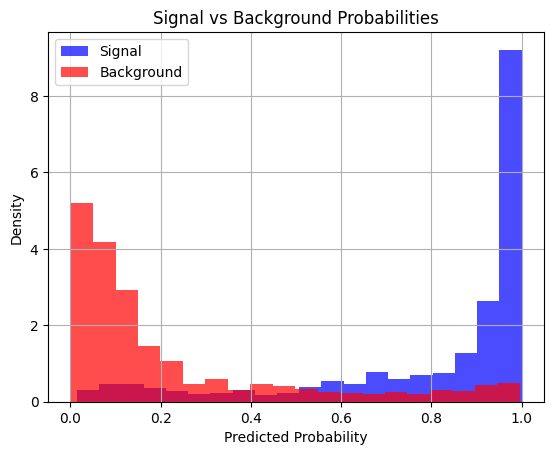

Precision: 0.9026, Recall: 0.7658, F1: 0.8286, ROC AUC: 0.9139

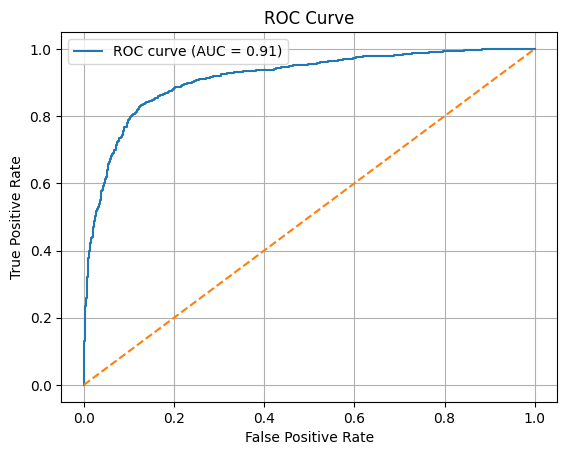

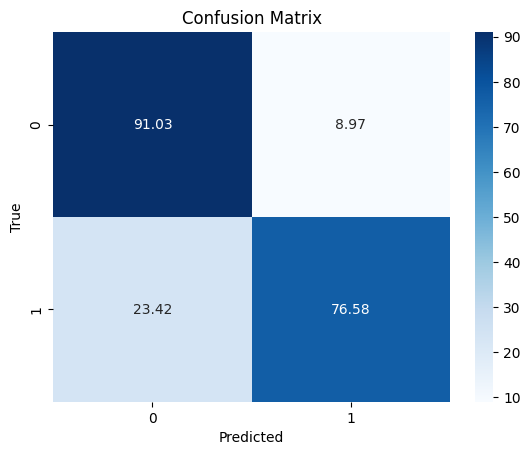

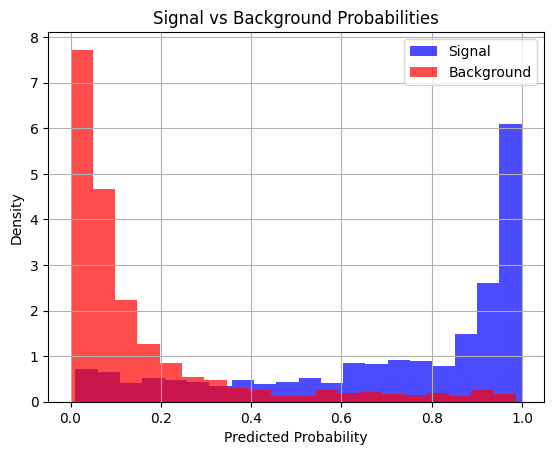

Precision: 0.8839, Recall: 0.7920, F1: 0.8355, ROC AUC: 0.9118

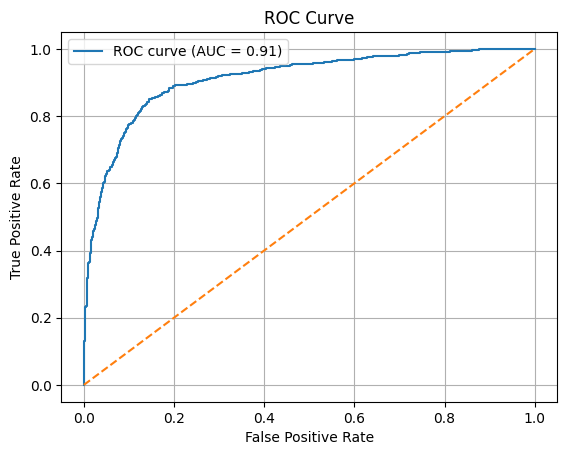

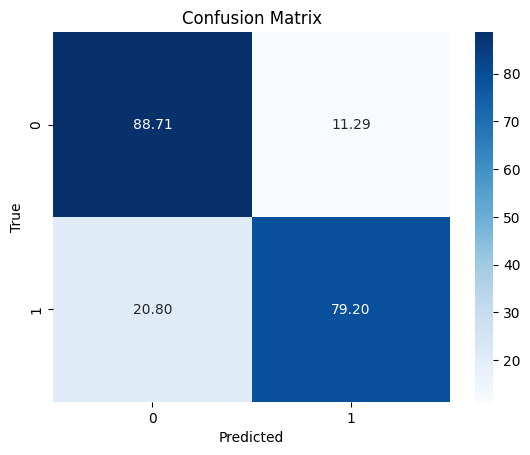

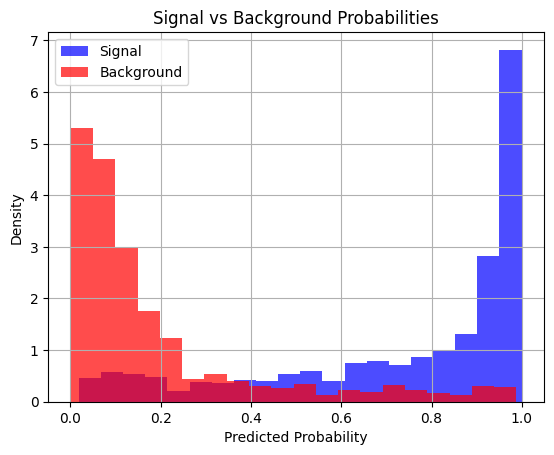

Precision: 0.8618, Recall: 0.8426, F1: 0.8521, ROC AUC: 0.9145

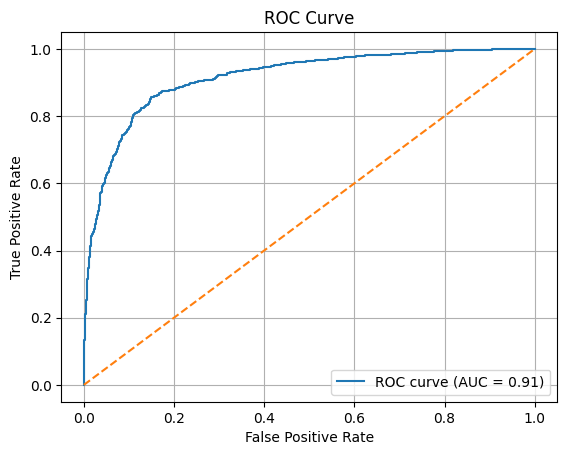

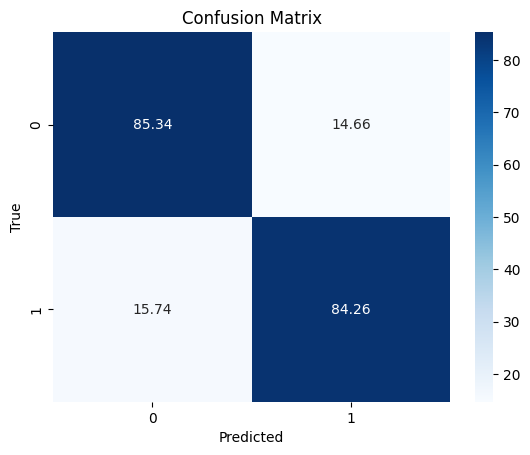

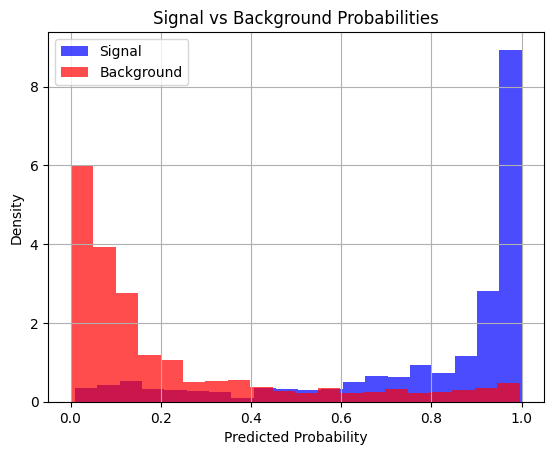

Precision: 0.8391, Recall: 0.8669, F1: 0.8528, ROC AUC: 0.9137

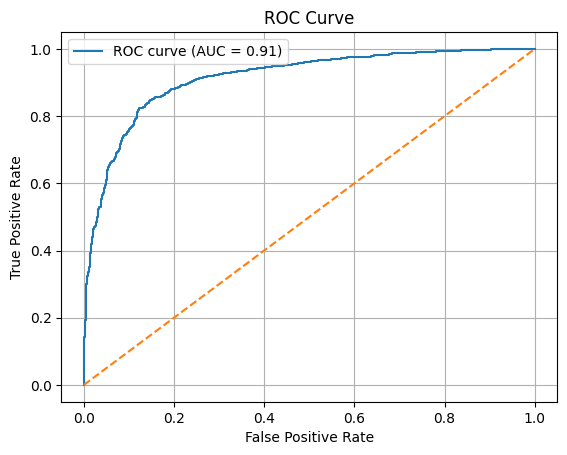

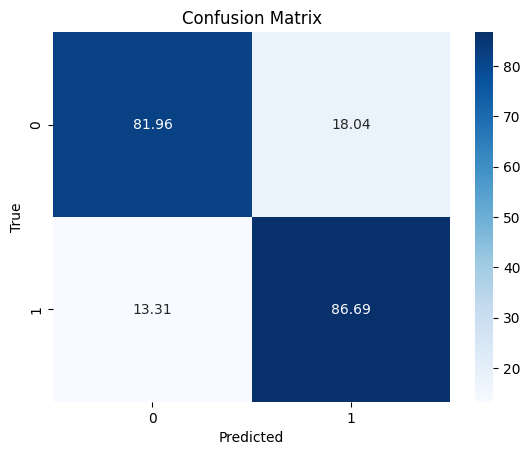

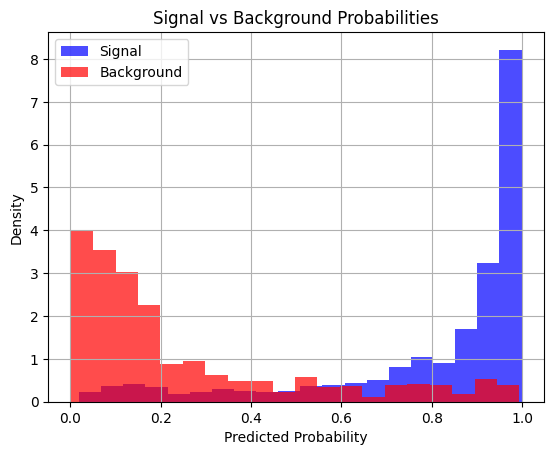

Precision: 0.8443, Recall: 0.8591, F1: 0.8516, ROC AUC: 0.9124

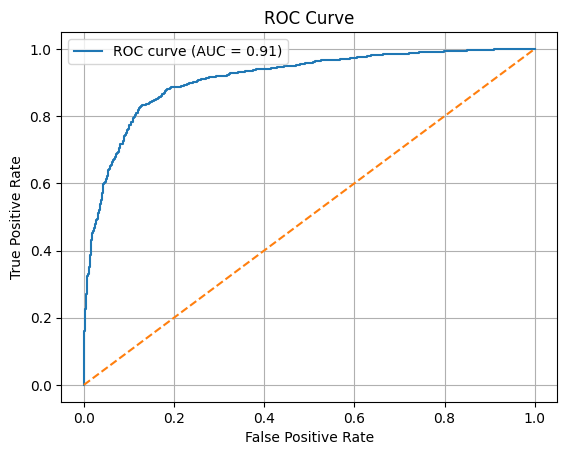

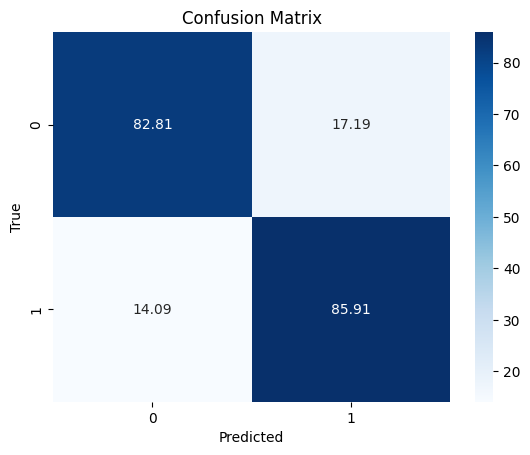

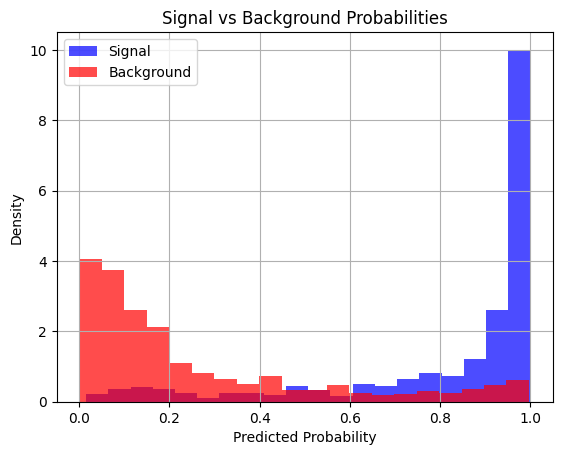

Precision: 0.8745, Recall: 0.8192, F1: 0.8460, ROC AUC: 0.9125

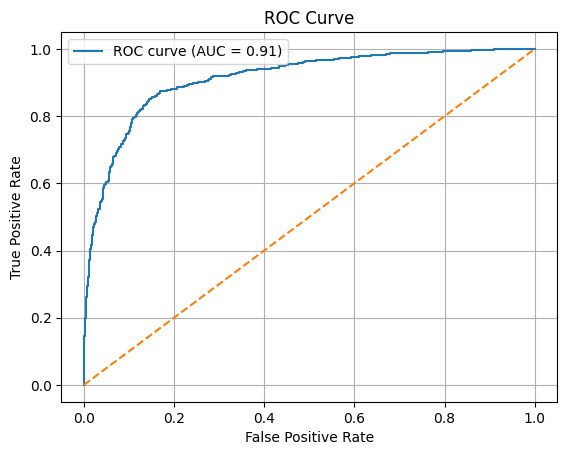

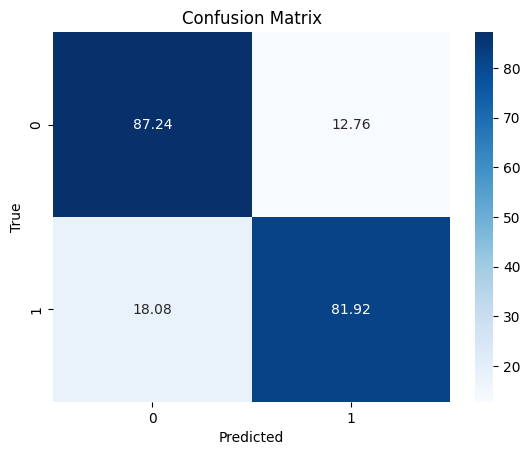

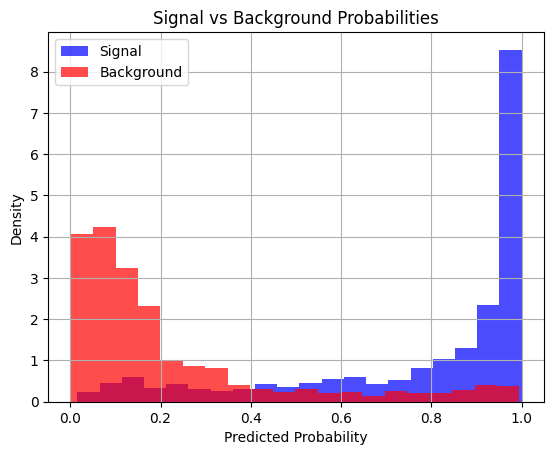

`Trainer.fit` stopped: `max_epochs=30` reached.


In [22]:

# Train the model
model = HyPERModel()
trainer = Trainer(max_epochs=30, accelerator='auto', logger=logger,callbacks=[checkpoint_cb],)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)



In [23]:
model = HyPERModel.load_from_checkpoint(
    "checkpoints/hyper-best.ckpt"
)
model.eval()
model.freeze()
